# Six Concentric Spheres Dataset
This script generates a synthetic dataset, named "Six Concentric Spheres", consisting of a series of 3D spheres nested within each other. Each sphere forms a distinct class, presenting a multi-class classification problem in a 3-dimensional space. The classification task is non-trivial due to the close proximity and overlaps of points belonging to different classes.

The generation process begins with setting parameters like the number of samples for each sphere, the radii of the spheres, and the noise level. The points are then generated on each sphere using uniformly distributed random angles (azimuth and inclination). Gaussian noise is added to these points to simulate real-world inconsistencies and make the classification task more challenging.

After the points on each sphere are generated, the script augments the dataset with additional features to further increase its complexity. These additional features include dummy variables with random values, features that are correlated with the original 'x', 'y', and 'z' features, and missing values introduced at random across the features.

Each record in the dataset contains a unique ID, the 'x', 'y', 'z' coordinates of the point, the target class (sphere number), and additional features. The target classes are represented as integers, starting from 0 for the innermost sphere and increasing for the outer spheres.

The script concludes with a 3D visualization of the dataset, using different colors, transparency levels, and marker sizes for each class. The visualization offers a clear picture of the nested spheres and their respective classes, helping to understand the intricacies of the classification task at hand.

The resulting Concentric Spheres dataset, with its multiclass, multi-feature complexity and inherent noise, offers a robust environment for benchmarking, understanding, and illustrating the performance of various machine learning algorithms. Despite its synthetic nature, it closely resembles practical scenarios where classification boundaries are not easily distinguishable.

In [92]:
import os
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt

In [93]:
dataset_name = 'six_concentric_spheres'

In [94]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_chart_fname = os.path.join(output_dir, f'{dataset_name}_plot.png')

# Generate Data

In [95]:
def set_seed(seed_value=0):
    np.random.seed(seed_value)
    random.seed(seed_value)

In [96]:
def generate_id(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [97]:
def generate_noisy_points_on_sphere(num_points, radius=1, noise_std_dev=0.1):
    points = np.empty((num_points, 3))

    phi = 2 * np.pi * np.random.rand(num_points)  # azimuthal angle
    z = radius * (2 * np.random.rand(num_points) - 1)  # z coordinates
    r_xy = np.sqrt(radius**2 - z**2)  # projected radius in the xy-plane

    points[:, 0] = r_xy * np.cos(phi)  # x coordinates
    points[:, 1] = r_xy * np.sin(phi)  # y coordinates
    points[:, 2] = z

    # Add Gaussian noise to each point
    noise = np.random.normal(scale=noise_std_dev, size=points.shape)
    points += noise

    return points

In [98]:
def generate_concentric_spheres(
        num_samples=[240, 735, 1500, 2535, 3840, 5415], 
        radii=[4, 7, 10, 13, 16, 19]):

    dfs = []
    for i, (num_points, radius) in enumerate(zip(num_samples, radii)):
        points = generate_noisy_points_on_sphere(num_points, radius=radius)
        df = pd.DataFrame(points, columns=['x', 'y', 'z'])
        df.insert(0, "sphere", i)
        dfs.append(df)

    data = pd.concat(dfs)
    data.insert(0, "id",  [generate_id() for _ in range(sum(num_samples))])
    return data

In [99]:
def add_dummy_features(df, num_features=67):
    for i in range(num_features):
        df[f'dummy_{i+1}'] = np.random.rand(len(df))
    return df

def add_correlated_features(df, correlation_factor=0.5):
    for feature in ['x', 'y', 'z']:
        noise = np.random.normal(scale=0.1, size=len(df))
        df[f'corr_{feature}'] = df[feature] * correlation_factor + noise
    return df

def add_missing_values(df, missing_fraction=0.05):
    for column in df.columns:
        if column not in ['id', 'sphere']:
            num_missing = int(missing_fraction * len(df))
            missing_indices = np.random.choice(df.index, num_missing, replace=False)
            df.loc[missing_indices, column] = np.nan
    return df

In [100]:
# Set seed for reproducibility
set_seed()

# Generate original dataset
data = generate_concentric_spheres()

# Add dummy features
data = add_dummy_features(data)

# Add correlated features
data = add_correlated_features(data)

# Add missing values
data = add_missing_values(data, missing_fraction=0.05)

print(data.shape)
print(data.head())

(14265, 75)
       id  sphere         x         y         z   dummy_1   dummy_2   dummy_3  \
0  Y0CQ65       0 -2.634570 -0.867808  2.884071       NaN       NaN       NaN   
1  ZT4WN6       0 -0.671839 -2.486998 -3.159058  0.306340  0.677972  0.516750   
2  ISIGQ8       0 -3.108666 -2.430462  0.143982  0.809120       NaN  0.916863   
3  JTGEV4       0 -2.552143 -0.689412 -3.100517  0.056274  0.091103  0.819825   
4  9GW1UN       0 -3.218104       NaN  1.565067  0.443345  0.058433       NaN   

    dummy_4   dummy_5  ...  dummy_61  dummy_62  dummy_63  dummy_64  dummy_65  \
0  0.581152  0.397647  ...  0.648593  0.754924       NaN  0.788681       NaN   
1  0.769210  0.449406  ...  0.691329  0.139243       NaN  0.479449  0.866878   
2  0.469258  0.964725  ...  0.910632  0.777139  0.524058  0.846995  0.646210   
3  0.055506       NaN  ...  0.684112  0.711163       NaN  0.073030  0.409908   
4  0.426187       NaN  ...  0.469190  0.410747  0.426167  0.444393  0.576064   

   dummy_66  dummy_6

# Visualize

In [101]:
def plot_and_save_3d_scatter(X, labels, filename=None):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    colors = plt.cm.viridis(np.linspace(0, 1, 6))  # Create a color map from dark to light
    alphas = np.linspace(0.4, 0.1, 6)  # Create transparency values from opaque to transparent
    sizes = np.linspace(30, 10, 6)  # Create marker sizes from large to small

    for target in range(6):
        mask = labels == target
        ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], color=colors[target],
                    label=f"Class {target}", alpha=alphas[target], s=sizes[target])

    plt.title('Synthetic 3D Concentric Spheres Dataset\n'  # main title
              '(Main dimensions defining the classes: x, y, z)',  # subtitle
              loc='center', fontsize=14)  # place the title to the left with font size 12

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # Move the legend to the right side with bbox_to_anchor argument
    ax.legend(bbox_to_anchor=(1.1, 0.6), loc='center left')

    if filename is not None:
        plt.savefig(filename)

    plt.show()

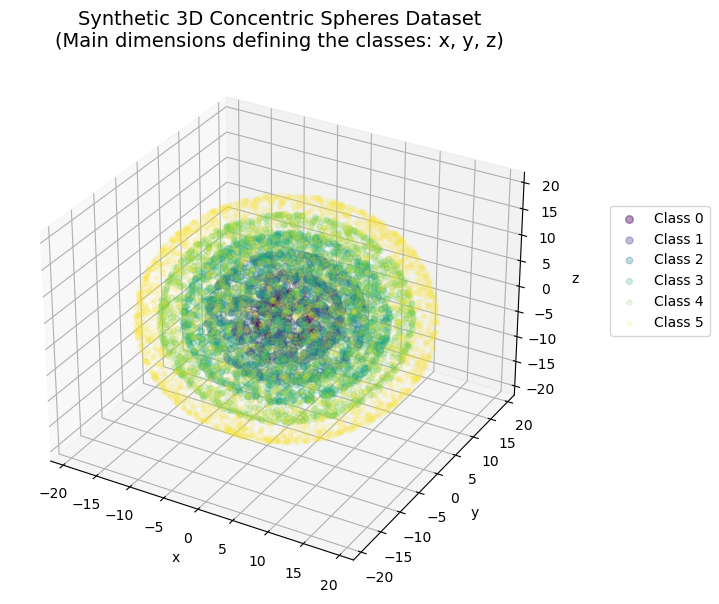

In [102]:
plot_and_save_3d_scatter(data[["x", "y", "z"]].values, data["sphere"], outp_chart_fname)

# Save Main Data File

In [104]:
data.to_csv(outp_fname, index=False, float_format="%.4f")